In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

In [3]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

2022-08-11 12:31:18.989824: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-08-11 12:31:19.017006: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-11 12:31:19.017031: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
file_path = "./Jan06_FlavFix_smear_1_std_xtd_zst.h5"

In [5]:
f5 = h5py.File(file_path, 'r')

In [12]:
x_train = np.array( f5['x_train'] )
y_train = to_categorical ( np.array( f5['y_train'] ) )
w_train = np.array( f5['w_train'] )

(array([[400610.,      0.,      0.,      0.,      0.,      0.,      0.,
              0.,      0., 300906.],
        [601755.,      0.,      0.,      0.,      0.,      0.,      0.,
              0.,      0.,  99761.],
        [400667.,      0.,      0.,      0.,      0.,      0.,      0.,
              0.,      0., 300849.]]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <a list of 3 BarContainer objects>)

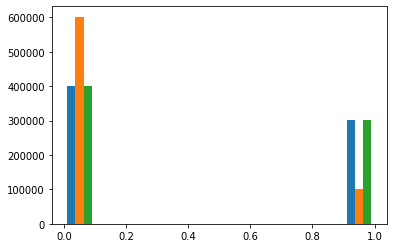

In [29]:
# x_train = x_train[:,:15,:]
#print(x_train.shape)
#print(y_train[15,1])
plt.hist(y_train[:])

In [32]:
print("x-shape: ", x_train.shape)
print("y-shape: ", y_train.shape)
print("w-shape: ", w_train.shape)

x-shape:  (701516, 15, 6)
y-shape:  (701516, 3)
w-shape:  (701516,)


In [6]:
print(x_train)

[[[-1.90562449e-01 -1.51768191e-02 -3.60630939e-01  4.87624739e-03
    7.29672852e-01 -9.82183589e-01]
  [-1.90693684e-01 -1.91545118e-03 -5.80833999e-01  4.31781846e-02
    1.22056850e-01 -4.08898653e-01]
  [ 5.29769396e-02  1.65169640e-02  4.14670362e-01  2.45462729e-02
   -6.13277289e-01  6.71777033e-01]
  ...
  [ 2.33517491e-02  2.63244143e+00  1.74061825e-01  2.58601275e+00
   -8.02894387e-01  9.94843555e-01]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00]]

 [[ 1.02449184e+00  5.74589139e-01  1.32411625e+00  4.22748161e-01
   -1.53972043e+00  9.63009351e-01]
  [ 1.69704721e-01  2.56993213e+00  1.59799224e+00  4.42930636e+00
   -1.12664531e+00 -6.42693874e-01]
  [-4.65999918e-02 -1.18592952e+00  1.72322546e-01 -1.91137920e+00
   -1.29164736e+00 -7.46956055e-02]
  ...
  [-2.10206523e-01 -2.71033332e+00 -8.97439126e-01 -2.63426

In [6]:
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, LSTM, Masking, Input, GRU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1

In [7]:
from tensorflow.keras import regularizers

GRU

In [8]:
def grumodel(max_len, n_var, rec_units, ndense=[10], l1_reg=0,
              l2_reg=0, rec_act='sigmoid', extra_lab='none', rec_kernel_init='VarianceScaling',
             dense_kernel_init='lecun_uniform', domask=False):
    
    rec_layer = 'GRU'
    
    track_inputs = Input(shape=(max_len, n_var,))
    
    if domask:
        hidden = Masking( mask_value=0, name="masking_1")(track_inputs)
    else:
        hidden = track_inputs
    

    if l1_reg > 1e-6 and l2_reg > 1e-6:
        hidden = GRU(units=rec_units,
                  kernel_initializer = rec_kernel_init, 
                  kernel_regularizer = regularizers.l1_l2(l1 = l1_reg, l2 = l2_reg),
                  name = 'gru_l1l2')(hidden)
    elif l1_reg > 1e-6:
        hidden = GRU(units=rec_units,
                  recurrent_activation = rec_act,
                  kernel_initializer = rec_kernel_init, 
                  kernel_regularizer = regularizers.l1(l1 = l1_reg),
                  name = 'gru_l1')(hidden)
    elif l2_reg > 1e-6:
        hidden = GRU(units=rec_units,
                  recurrent_activation = rec_act,
                  kernel_initializer = rec_kernel_init, 
                  kernel_regularizer = regularizers.l2(l2 = l2_reg),
                  name = 'gru_l2')(hidden)
    else:
        hidden = GRU(units=rec_units,
                  recurrent_activation = rec_act,
                  kernel_initializer = rec_kernel_init, 
                  name = 'gru')(hidden)
            

    for ind,nd in enumerate(ndense):
        hidden = Dense(nd, activation='relu', kernel_initializer=dense_kernel_init, name=f'dense_{ind}' )(hidden)
    
    output = Dense(3, activation='softmax', kernel_initializer=dense_kernel_init, name = 'output_softmax')(hidden)
    
    model = Model(inputs=track_inputs, outputs=output)
    
    d_layers = ''.join([ str(dl) for dl in ndense ])
        
    if domask:
        mname  = f'MASKED_rnn_{rec_layer}.{rec_units}_Dense.{d_layers}_'
    else:
        mname  = f'rnn_{rec_layer}.{rec_units}_Dense.{d_layers}_'
    mname += f'LSTMKernelInit.{rec_kernel_init}_DenseKernelInit.{dense_kernel_init}'
    mname += f'KRl1.{l1_reg}_KRl2.{l2_reg}_recAct.{rec_act}' #LSTM kernel regularizer
    
    if 'none' not in extra_lab:
        mname += f'_{extra_lab}'
    
    return model, mname

#     mask = Masking( mask_value=0, name="masking_1")(track_inputs)
##########################################
#                   use_bias=False,
#                   activation='relu',
#                   recurrent_activation='relu',
#                   kernel_regularizer = regularizers.l1_l2(l1= 0.001, l2 = 0.0001), 
#                   bias_regularizer = regularizers.l1_l2(l1= 1, l2 = 1), 
#                   activity_regularizer=regularizers.l1_l2(l1= 0.001, l2 = 0.0001),
##########################################

QGRU

In [8]:
import qkeras
from qkeras import *

In [9]:
def qgrumodel(max_len, n_var, rec_units, ndense=[10], l1_reg=0,
              l2_reg=0, rec_act='sigmoid', extra_lab='none', rec_kernel_init='VarianceScaling',
             dense_kernel_init='lecun_uniform', domask=False, quantization_bits=18, int_bits = 6):
    
    rec_layer = 'QGRU'
    
    track_inputs = Input(shape=(max_len, n_var,))
    
    if domask:
        hidden = Masking( mask_value=0, name="masking_1")(track_inputs)
    else:
        hidden = track_inputs
    

    if l1_reg > 1e-6 and l2_reg > 1e-6:
        hidden = QGRU(units=rec_units,
                  kernel_initializer = rec_kernel_init, 
                  kernel_regularizer = regularizers.l1_l2(l1 = l1_reg, l2 = l2_reg),
#                   kernel_quantizer=quantized_bits(quantization_bits,int_bits,alpha=1),
#                   recurrent_quantizer=quantized_bits(quantization_bits,int_bits,alpha=1),
#                   bias_quantizer=quantized_bits(quantization_bits,int_bits,alpha=1),
#                   state_quantizer=quantized_bits(quantization_bits,int_bits,alpha=1),
                  kernel_quantizer=quantized_bits(quantization_bits,int_bits,1),
                  recurrent_quantizer=quantized_bits(quantization_bits,int_bits,1),
                  bias_quantizer=quantized_bits(quantization_bits,int_bits,1),
                  state_quantizer=quantized_bits(quantization_bits,int_bits,1),
                  name = 'qgru_l1l2')(hidden)
    elif l1_reg > 1e-6:
        hidden = QGRU(units=rec_units,
                  recurrent_activation = rec_act,
                  kernel_initializer = rec_kernel_init, 
                  kernel_regularizer = regularizers.l1(l1 = l1_reg),
#                   kernel_quantizer=quantized_bits(quantization_bits,int_bits,alpha=1),
#                   recurrent_quantizer=quantized_bits(quantization_bits,int_bits,alpha=1),
#                   bias_quantizer=quantized_bits(quantization_bits,int_bits,alpha=1),
#                   state_quantizer=quantized_bits(quantization_bits,int_bits,alpha=1),
                  kernel_quantizer=quantized_bits(quantization_bits,int_bits,1),
                  recurrent_quantizer=quantized_bits(quantization_bits,int_bits,1),
                  bias_quantizer=quantized_bits(quantization_bits,int_bits,1),
                  state_quantizer=quantized_bits(quantization_bits,int_bits,1),
                  name = 'qgru_l1')(hidden)
    elif l2_reg > 1e-6:
        hidden = QGRU(units=rec_units,
                  recurrent_activation = rec_act,
                  kernel_initializer = rec_kernel_init, 
                  kernel_regularizer = regularizers.l2(l2 = l2_reg),
#                   kernel_quantizer=quantized_bits(quantization_bits,int_bits,alpha=1),
#                   recurrent_quantizer=quantized_bits(quantization_bits,int_bits,alpha=1),
#                   bias_quantizer=quantized_bits(quantization_bits,int_bits,alpha=1),
#                   state_quantizer=quantized_bits(quantization_bits,int_bits,alpha=1),
                  kernel_quantizer=quantized_bits(quantization_bits,int_bits,1),
                  recurrent_quantizer=quantized_bits(quantization_bits,int_bits,1),
                  bias_quantizer=quantized_bits(quantization_bits,int_bits,1),
                  state_quantizer=quantized_bits(quantization_bits,int_bits,1),
                  name = 'qgru_l2')(hidden)
    else:
        hidden = QGRU(units=rec_units,
                  recurrent_activation = rec_act,
                  kernel_initializer = rec_kernel_init,
#                   kernel_quantizer=quantized_bits(quantization_bits,int_bits,alpha=1),
#                   recurrent_quantizer=quantized_bits(quantization_bits,int_bits,alpha=1),
#                   bias_quantizer=quantized_bits(quantization_bits,int_bits,alpha=1),
#                   state_quantizer=quantized_bits(quantization_bits,int_bits,alpha=1),
                  kernel_quantizer=quantized_bits(quantization_bits,int_bits,1),
                  recurrent_quantizer=quantized_bits(quantization_bits,int_bits,1),
                  bias_quantizer=quantized_bits(quantization_bits,int_bits,1),
                  state_quantizer=quantized_bits(quantization_bits,int_bits,1),
                  name = 'qgru')(hidden)
            

    for ind,nd in enumerate(ndense):
        hidden = QDense(nd, activation='relu',
                        kernel_initializer=dense_kernel_init,
#                         kernel_quantizer=quantized_bits(quantization_bits,int_bits,alpha=1),
#                         bias_quantizer=quantized_bits(quantization_bits,int_bits,alpha=1),
                        kernel_quantizer=quantized_bits(quantization_bits,int_bits,1),
                        bias_quantizer=quantized_bits(quantization_bits,int_bits,1),
                        name=f'dense_{ind}' )(hidden)
    
    output = QDense(3, activation='softmax',
                    kernel_initializer=dense_kernel_init,
#                     kernel_quantizer=quantized_bits(quantization_bits,int_bits,alpha=1),
#                     bias_quantizer=quantized_bits(quantization_bits,int_bits,alpha=1),
                    kernel_quantizer=quantized_bits(quantization_bits,int_bits,1),
                    bias_quantizer=quantized_bits(quantization_bits,int_bits,1),
                    name = 'output_softmax')(hidden)
    
    model = Model(inputs=track_inputs, outputs=output)
    
    d_layers = ''.join([ str(dl) for dl in ndense ])
        
    if domask:
        mname  = f'MASKED_rnn_{rec_layer}.{rec_units}_Dense.{d_layers}_'
    else:
        mname  = f'rnn_{rec_layer}.{rec_units}_Dense.{d_layers}_'
    mname += f'LSTMKernelInit.{rec_kernel_init}_DenseKernelInit.{dense_kernel_init}'
    mname += f'KRl1.{l1_reg}_KRl2.{l2_reg}_recAct.{rec_act}' #LSTM kernel regularizer
    
    if 'none' not in extra_lab:
        mname += f'_{extra_lab}'
    
    return model, mname

#     mask = Masking( mask_value=0, name="masking_1")(track_inputs)
##########################################
#                   use_bias=False,
#                   activation='relu',
#                   recurrent_activation='relu',
#                   kernel_regularizer = regularizers.l1_l2(l1= 0.001, l2 = 0.0001), 
#                   bias_regularizer = regularizers.l1_l2(l1= 1, l2 = 1), 
#                   activity_regularizer=regularizers.l1_l2(l1= 0.001, l2 = 0.0001),
##########################################

LSTM

In [9]:
def lstmmodel(max_len, n_var, rec_units, ndense=[10], l1_reg=0,
              l2_reg=0, rec_act='sigmoid', extra_lab='none', rec_kernel_init='VarianceScaling',
             dense_kernel_init='lecun_uniform', domask=False):
    
    rec_layer = 'LSTM'
    
    track_inputs = Input(shape=(max_len, n_var,))
    
    if domask:
        hidden = Masking( mask_value=0, name="masking_1")(track_inputs)
    else:
        hidden = track_inputs
    
    if l1_reg > 1e-6 and l2_reg > 1e-6:
        hidden = LSTM(units=rec_units,
                  recurrent_activation = rec_act,
                  kernel_initializer = rec_kernel_init, 
                  kernel_regularizer = regularizers.l1_l2(l1 = l1_reg, l2 = l2_reg),
                  name = 'lstm1_l1l2')(hidden)
    elif l1_reg > 1e-6:
        hidden = LSTM(units=rec_units,
                  recurrent_activation = rec_act,
                  kernel_initializer = rec_kernel_init, 
                  kernel_regularizer = regularizers.l1(l1 = l1_reg),
                  name = 'lstm1_l1')(hidden)
    elif l2_reg > 1e-6:
        hidden = LSTM(units=rec_units,
                  recurrent_activation = rec_act,
                  kernel_initializer = rec_kernel_init, 
                  kernel_regularizer = regularizers.l2(l2 = l2_reg),
                  name = 'lstm1_l2')(hidden)
    else:
        hidden = LSTM(units=rec_units,
                  recurrent_activation = rec_act,
                  kernel_initializer = rec_kernel_init, 
                  name = 'lstm1')(hidden)

    for ind,nd in enumerate(ndense):
        hidden = Dense(nd, activation='relu', kernel_initializer=dense_kernel_init, name=f'dense_{ind}' )(hidden)
    
    output = Dense(3, activation='softmax', kernel_initializer=dense_kernel_init, name = 'output_softmax')(hidden)
    
    model = Model(inputs=track_inputs, outputs=output)
    
    d_layers = ''.join([ str(dl) for dl in ndense ])
        
    if domask:
        mname  = f'MASKED_rnn_{rec_layer}.{rec_units}_Dense.{d_layers}_'
    else:
        mname  = f'rnn_{rec_layer}.{rec_units}_Dense.{d_layers}_'
    mname += f'LSTMKernelInit.{rec_kernel_init}_DenseKernelInit.{dense_kernel_init}'
    mname += f'KRl1.{l1_reg}_KRl2.{l2_reg}_recAct.{rec_act}' #LSTM kernel regularizer
    
    if 'none' not in extra_lab:
        mname += f'_{extra_lab}'
    
    return model, mname

#     mask = Masking( mask_value=0, name="masking_1")(track_inputs)
##########################################
#                   use_bias=False,
#                   activation='relu',
#                   recurrent_activation='relu',
#                   kernel_regularizer = regularizers.l1_l2(l1= 0.001, l2 = 0.0001), 
#                   bias_regularizer = regularizers.l1_l2(l1= 1, l2 = 1), 
#                   activity_regularizer=regularizers.l1_l2(l1= 0.001, l2 = 0.0001),
##########################################

QLSTM

In [2]:
def qlstmmodel(max_len, n_var, rec_units, ndense=[10], l1_reg=0,
              l2_reg=0, rec_act='sigmoid', extra_lab='none', rec_kernel_init='VarianceScaling',
             dense_kernel_init='lecun_uniform', domask=False, quantization_bits=0, int_bits =0):
    
    rec_layer = 'QLSTM'
    
    track_inputs = Input(shape=(max_len, n_var,))
    
    if domask:
        hidden = Masking( mask_value=0, name="masking_1")(track_inputs)
    else:
        hidden = track_inputs
    
    if l1_reg > 1e-6 and l2_reg > 1e-6:
        hidden = QLSTM(units=rec_units,
                  recurrent_activation = rec_act,
                  kernel_initializer = rec_kernel_init, 
                  kernel_regularizer = regularizers.l1_l2(l1 = l1_reg, l2 = l2_reg),
                  kernel_quantizer=quantized_bits(quantization_bits,int_bits,1),
                  recurrent_quantizer=quantized_bits(quantization_bits,int_bits,1),
                  bias_quantizer=quantized_bits(quantization_bits,int_bits,1),
                  state_quantizer=quantized_bits(quantization_bits,int_bits,1),
                  name = 'qlstm1_l1l2')(hidden)
    elif l1_reg > 1e-6:
        hidden = QLSTM(units=rec_units,
                  recurrent_activation = rec_act,
                  kernel_initializer = rec_kernel_init, 
                  kernel_regularizer = regularizers.l1(l1 = l1_reg),
                  kernel_quantizer=quantized_bits(quantization_bits,int_bits,1),
                  recurrent_quantizer=quantized_bits(quantization_bits,int_bits,1),
                  bias_quantizer=quantized_bits(quantization_bits,int_bits,1),
                  state_quantizer=quantized_bits(quantization_bits,int_bits,1),
                  name = 'qlstm1_l1')(hidden)
    elif l2_reg > 1e-6:
        hidden = QLSTM(units=rec_units,
                  recurrent_activation = rec_act,
                  kernel_initializer = rec_kernel_init, 
                  kernel_regularizer = regularizers.l2(l2 = l2_reg),
                  kernel_quantizer=quantized_bits(quantization_bits,int_bits,1),
                  recurrent_quantizer=quantized_bits(quantization_bits,int_bits,1),
                  bias_quantizer=quantized_bits(quantization_bits,int_bits,1),
                  state_quantizer=quantized_bits(quantization_bits,int_bits,1),
                  name = 'qlstm1_l2')(hidden)
    else:
        hidden = QLSTM(units=rec_units,
                  recurrent_activation = rec_act,
                  kernel_initializer = rec_kernel_init, 
                  kernel_quantizer=quantized_bits(quantization_bits,int_bits,1),
                  recurrent_quantizer=quantized_bits(quantization_bits,int_bits,1),
                  bias_quantizer=quantized_bits(quantization_bits,int_bits,1),
                  state_quantizer=quantized_bits(quantization_bits,int_bits,1),
                  name = 'qlstm1')(hidden)

    for ind,nd in enumerate(ndense):
        hidden = QDense(nd, activation='relu',
                        kernel_quantizer=quantized_bits(quantization_bits,int_bits,1),
                        bias_quantizer=quantized_bits(quantization_bits,int_bits,1),
                        kernel_initializer=dense_kernel_init, name=f'dense_{ind}' )(hidden)
    
    output = QDense(3, activation='softmax',
                    kernel_quantizer=quantized_bits(quantization_bits,int_bits,1),
                    bias_quantizer=quantized_bits(quantization_bits,int_bits,1),
                    kernel_initializer=dense_kernel_init, name = 'output_softmax')(hidden)
    
    model = Model(inputs=track_inputs, outputs=output)
    
    d_layers = ''.join([ str(dl) for dl in ndense ])
        
    if domask:
        mname  = f'MASKED_rnn_{rec_layer}.{rec_units}_Dense.{d_layers}_'
    else:
        mname  = f'rnn_{rec_layer}.{rec_units}_Dense.{d_layers}_'
    mname += f'LSTMKernelInit.{rec_kernel_init}_DenseKernelInit.{dense_kernel_init}'
    mname += f'KRl1.{l1_reg}_KRl2.{l2_reg}_recAct.{rec_act}' #LSTM kernel regularizer
    
    if 'none' not in extra_lab:
        mname += f'_{extra_lab}'
    
    return model, mname

#     mask = Masking( mask_value=0, name="masking_1")(track_inputs)
##########################################
#                   use_bias=False,
#                   activation='relu',
#                   recurrent_activation='relu',
#                   kernel_regularizer = regularizers.l1_l2(l1= 0.001, l2 = 0.0001), 
#                   bias_regularizer = regularizers.l1_l2(l1= 1, l2 = 1), 
#                   activity_regularizer=regularizers.l1_l2(l1= 0.001, l2 = 0.0001),
##########################################

Train Model

In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

In [11]:
x_test = np.array( f5['x_test'] )
y_test = to_categorical ( np.array( f5['y_test'] ) )

Check Model

In [12]:
l1_reg = 0
l2_reg = 0

## GRU Model
#model, model_name = grumodel(15, 6, 120, [50, 10],l1_reg=l1_reg, l2_reg=l2_reg)

## LSTM Model
#model, model_name = lstmmodel(15, 6, 120, [50, 10],l1_reg=l1_reg, l2_reg=l2_reg)

## QGRU Model
#model, model_name = qgrumodel(15, 6, 120, [50, 10],l1_reg=l1_reg, l2_reg=l2_reg, quantization_bits=4, int_bits = 2)

## QLSTM Model
model, model_name = qlstmmodel(15, 6, 120, [50, 10],l1_reg=l1_reg, l2_reg=l2_reg, quantization_bits=4, int_bits = 2)

model.summary()

2022-08-04 12:51:25.219382: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-04 12:51:25.220084: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-04 12:51:25.220181: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-CHSBCRQ): /proc/driver/nvidia/version does not exist
2022-08-04 12:51:25.222594: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 15, 6)]           0         
                                                                 
 qlstm1 (QLSTM)              (None, 120)               60960     
                                                                 
 dense_0 (QDense)            (None, 50)                6050      
                                                                 
 dense_1 (QDense)            (None, 10)                510       
                                                                 
 output_softmax (QDense)     (None, 3)                 33        
                                                                 
Total params: 67,553
Trainable params: 67,553
Non-trainable params: 0
_________________________________________________________________


In [14]:
roc = []
for i in [2, 4, 6, 8, 10, 12, 14]:
    print("i=", i)
    l1_reg = 0
    l2_reg = 0

    ## GRU Model
    #model, model_name = grumodel(15, 6, 120, [50, 10], l1_reg=l1_reg, l2_reg=l2_reg)
    
    
    ## QGRU Model
    model, model_name = qgrumodel(15, 6, 120, [50, 10], l1_reg=l1_reg, l2_reg=l2_reg, quantization_bits=i+2, int_bits = 2)
    
    
    ## LSTM Model
    #model, model_name = lstmmodel(15, 6, 120, [50, 10], l1_reg=l1_reg, l2_reg=l2_reg)
    
    
    # QLSTM Model
    #model, model_name = qlstmmodel(15, 6, 120, [50, 10],l1_reg=l1_reg, l2_reg=l2_reg, quantization_bits=i, int_bits = 0)
       
    adam = Adam(learning_rate=0.01)
    model.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'], weighted_metrics=[])
    model_output = f'epoch_0807_2int2fra/model_{i}frac_weights.h5'
    train = True
    if train:
        history = model.fit( x_train , y_train,
                batch_size=2**14,
                epochs=i,
                validation_split=0.1,
                shuffle = True,
                sample_weight= w_train,
                callbacks = [
                    EarlyStopping(verbose=True, patience=15, monitor='val_accuracy'),
                    ModelCheckpoint(model_output, monitor='val_accuracy', verbose=True, save_best_only=True)
                    ],
                verbose=True
                )

    model.load_weights(model_output)
    pred_test = model.predict(x_test, batch_size=2**10)
    roc_score = roc_auc_score(y_test, pred_test)
    print("roc_score:", roc_score)
    roc.append(roc_score)

i= 15
Epoch 1/15
39/39 [==============================] - ETA: 0s - loss: 0.8693 - accuracy: 0.6175
Epoch 1: val_accuracy improved from -inf to 0.68173, saving model to epoch_0807_2int2fra/model_15epoch_weights.h5
39/39 [==============================] - 77s 2s/step - loss: 0.8693 - accuracy: 0.6175 - val_loss: 0.7847 - val_accuracy: 0.6817
Epoch 2/15
39/39 [==============================] - ETA: 0s - loss: 0.7661 - accuracy: 0.6886
Epoch 2: val_accuracy improved from 0.68173 to 0.69804, saving model to epoch_0807_2int2fra/model_15epoch_weights.h5
39/39 [==============================] - 58s 1s/step - loss: 0.7661 - accuracy: 0.6886 - val_loss: 0.7474 - val_accuracy: 0.6980
Epoch 3/15
39/39 [==============================] - ETA: 0s - loss: 0.7369 - accuracy: 0.7036
Epoch 3: val_accuracy improved from 0.69804 to 0.70990, saving model to epoch_0807_2int2fra/model_15epoch_weights.h5
39/39 [==============================] - 58s 1s/step - loss: 0.7369 - accuracy: 0.7036 - val_loss: 0.7291 